# Generative modelling in deep learning

###### Student Name : Ayush K. Rai
###### Program : MSc in Artificial Intelligence

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

* Information Theoretic approaches like KL Divergence  
$KL(P||Q) = \sum P(x) \log \frac{P(x)}{Q(x)}$  
Also Jensen Shanon Divergence, which is the average Kullback-Leibler divergence of X and Y from their mixture distribution, M  
* Kernel Density Estimation approaches like Mean Maximum Discrepancy (MMD)  
$MMD(P, Q) = \lVert E_{X \sim P}[ \varphi(X) ] - E_{Y \sim Q}[ \varphi(Y) ] \rVert_h$, where feature map $\varphi:X \mapsto X$ and $H$ is kernel hilbert space.
* There are few other approaches like Earth Mover Distance

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

* Divergence based methods like KL and JSD requires density estimation.
* MMD is non parametric method and doesn't require any density estimation.  
In General both have their pros and cons.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> Different choices of dimension of the input noise encode interpretable factors of variation. For example : in case the task is to generate face images then varying noise along one dimension could correspond to varying degree of smile in the generated image while varying noise along another dimension could correspond to varying head pose of the generated face image.

By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> Using JSD as a training objective for the generator might lead to vanishing gradient problem.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> It means that generator can still learn even when discriminator successfully rejects all the generator samples.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [4]:
import torch
from torch.autograd import Variable

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

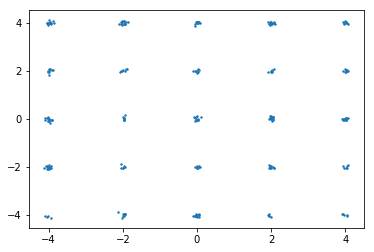

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [106]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 4
LAYER_SIZE = 8

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, LAYER_SIZE)
        self.fc2 = nn.Linear(LAYER_SIZE, LAYER_SIZE)
        self.fc3 = nn.Linear(LAYER_SIZE, 2)
        
    def __call__(self, z):
        h1 = F.relu(self.fc1(z))
        h2 = F.relu(self.fc2(h1))
        h = self.fc3(h2)
        return h
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, LAYER_SIZE)
        self.fc2 = nn.Linear(LAYER_SIZE, LAYER_SIZE)
        self.fc3 = nn.Linear(LAYER_SIZE, 1)
    
    def __call__(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h = self.fc3(h2)
        return h

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.505e+00, generator: 6.534e-01


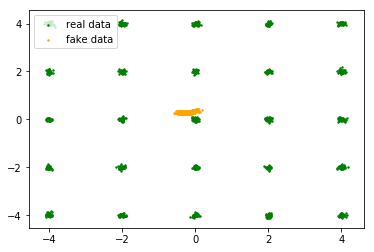

step 1000: discriminator: 9.110e-01, generator: 1.496e+00


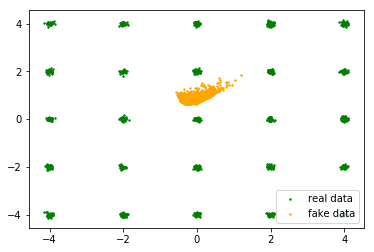

step 2000: discriminator: 7.919e-01, generator: 3.191e+00


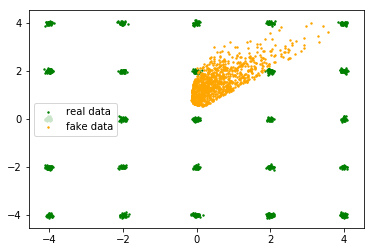

step 3000: discriminator: 8.701e-01, generator: 4.211e+00


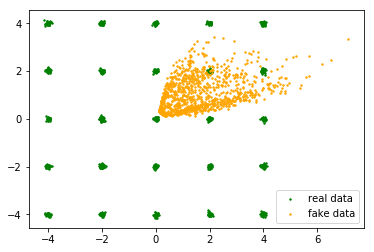

step 4000: discriminator: 8.756e-01, generator: 5.511e+00


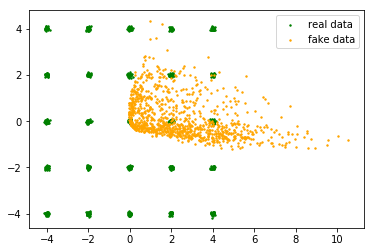

step 5000: discriminator: 8.972e-01, generator: 4.915e+00


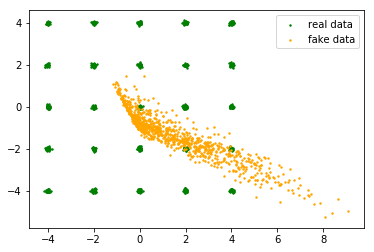

step 6000: discriminator: 9.032e-01, generator: 7.413e+00


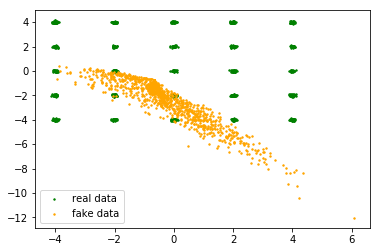

step 7000: discriminator: 1.083e+00, generator: 1.450e+01


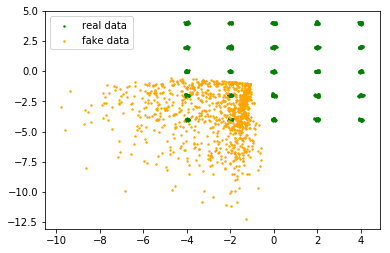

step 8000: discriminator: 9.427e-01, generator: 1.518e+01


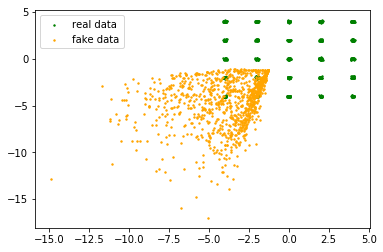

step 9000: discriminator: 9.206e-01, generator: 1.369e+01


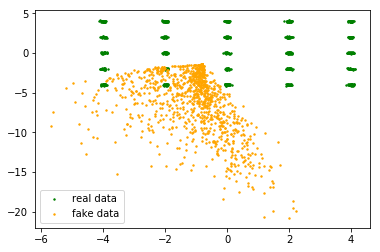

step 10000: discriminator: 9.322e-01, generator: 1.535e+01


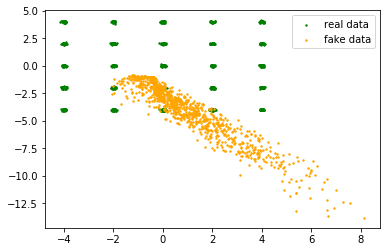

step 11000: discriminator: 1.466e+00, generator: 1.490e+01


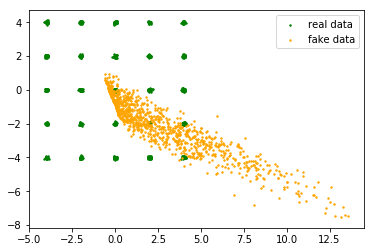

step 12000: discriminator: 1.146e+01, generator: 1.022e+01


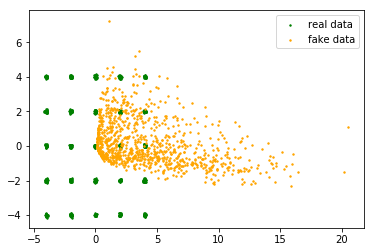

step 13000: discriminator: 1.457e+00, generator: 2.233e+01


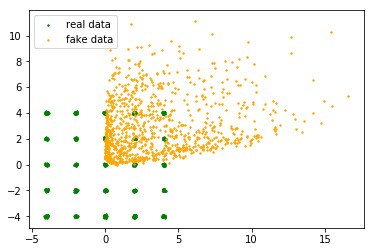

step 14000: discriminator: 1.175e+00, generator: 3.042e+01


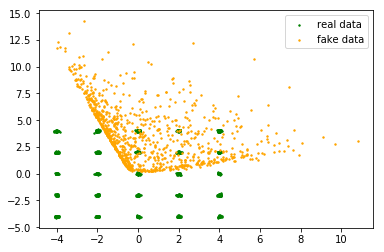

step 15000: discriminator: 1.166e+00, generator: 1.809e+01


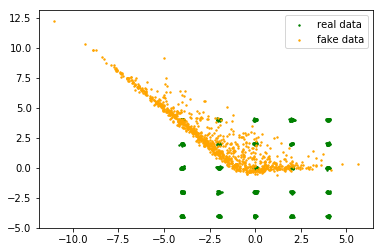

step 16000: discriminator: 1.339e+00, generator: 1.675e+01


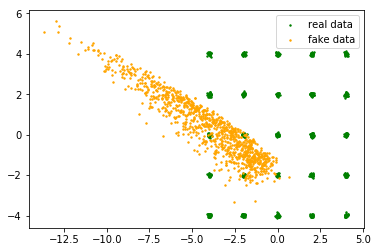

step 17000: discriminator: 1.386e+00, generator: 2.067e+01


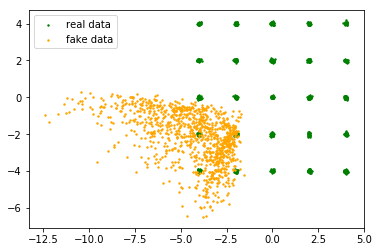

step 18000: discriminator: 1.386e+00, generator: 2.329e+01


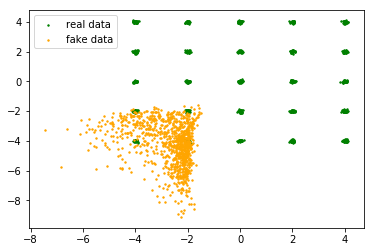

step 19000: discriminator: 1.386e+00, generator: 1.933e+01


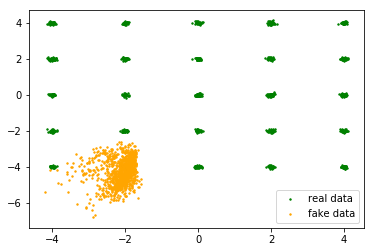

step 20000: discriminator: 1.386e+00, generator: 1.773e+01


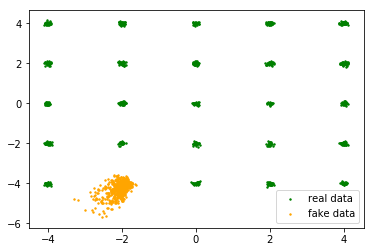

step 21000: discriminator: 1.386e+00, generator: 1.699e+01


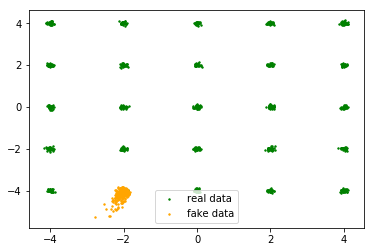

step 22000: discriminator: 1.386e+00, generator: 1.677e+01


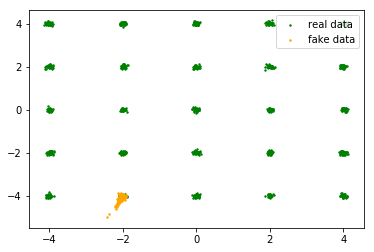

step 23000: discriminator: 1.386e+00, generator: 1.669e+01


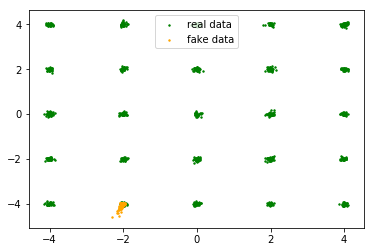

step 24000: discriminator: 1.386e+00, generator: 1.666e+01


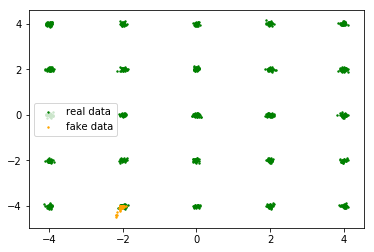

step 25000: discriminator: 1.386e+00, generator: 1.666e+01


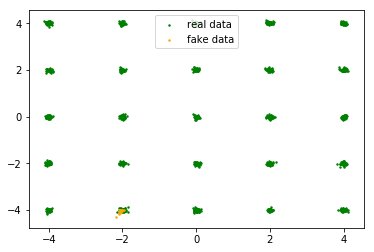

step 26000: discriminator: 1.386e+00, generator: 1.665e+01


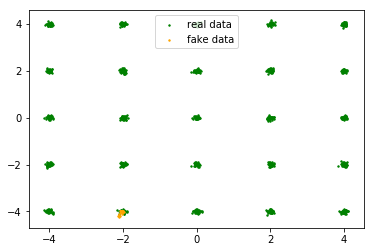

step 27000: discriminator: 1.386e+00, generator: 1.665e+01


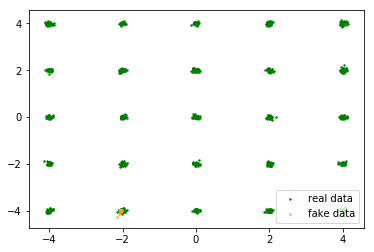

step 28000: discriminator: 1.386e+00, generator: 1.665e+01


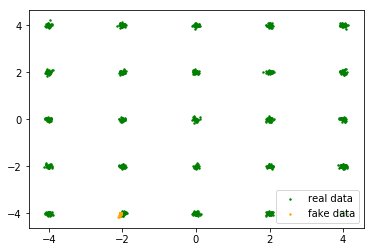

step 29000: discriminator: 1.386e+00, generator: 1.664e+01


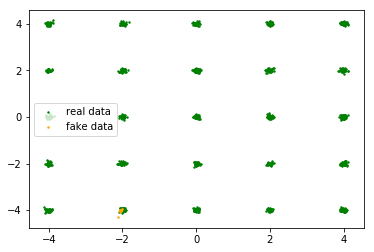

step 30000: discriminator: 1.386e+00, generator: 1.664e+01


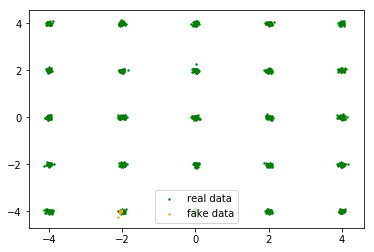

step 31000: discriminator: 1.386e+00, generator: 1.664e+01


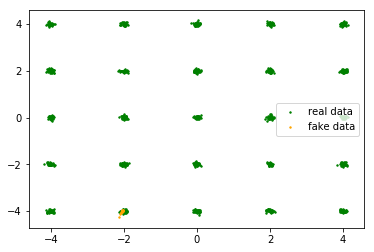

step 32000: discriminator: 1.386e+00, generator: 1.664e+01


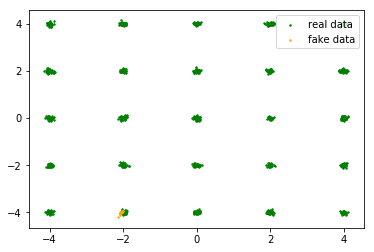

step 33000: discriminator: 1.386e+00, generator: 1.664e+01


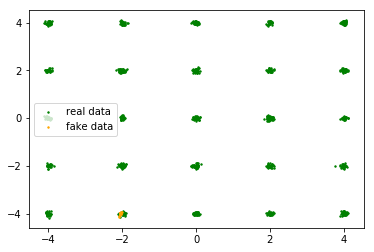

step 34000: discriminator: 1.386e+00, generator: 1.664e+01


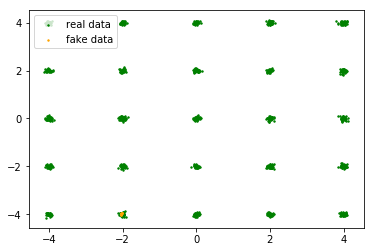

step 35000: discriminator: 1.386e+00, generator: 1.664e+01


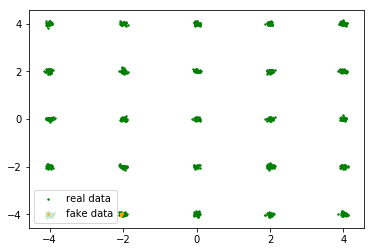

step 36000: discriminator: 1.386e+00, generator: 1.664e+01


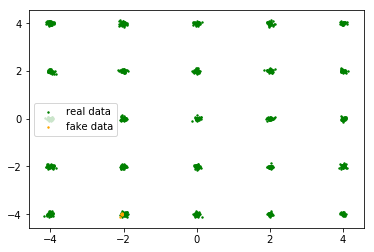

step 37000: discriminator: 1.386e+00, generator: 1.665e+01


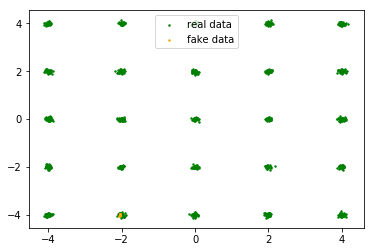

step 38000: discriminator: 1.386e+00, generator: 1.664e+01


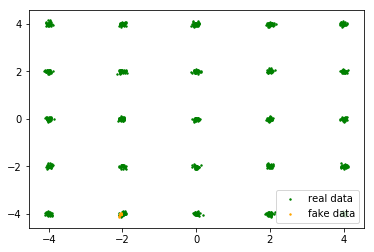

step 39000: discriminator: 1.386e+00, generator: 1.664e+01


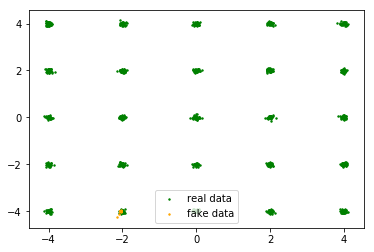

step 40000: discriminator: 1.386e+00, generator: 1.665e+01


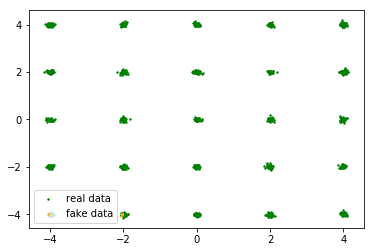

In [107]:
dtype = torch.FloatTensor

def compute_bce_loss(input_, target):
    """
    Compute Binary Cross Entropy Loss
    """
    neg_abs = - input_.abs()
    loss = input_.clamp(min=0) - input_ * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes Discriminator Loss
    """
    
    logits_real = F.softplus(logits_real)
    logits_fake = F.softplus(logits_fake)
    N, _ = logits_real.size()
    loss = (compute_bce_loss(logits_real, Variable(torch.ones(N)).type(dtype)) +
            compute_bce_loss(logits_fake, Variable(torch.zeros(N)).type(dtype)))
    return loss

def generator_loss(logits_fake):
    """
    Computes the Generator Loss
    """
    N, _ = logits_fake.size()
    loss = compute_bce_loss(logits_fake, Variable(torch.ones(N)).type(dtype))
    return loss

#-----------------------------------------------------------------------------------------

# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 3
# Total number of training iterations for the generator
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        real_logits = discriminator(real_batch).type(dtype)
        fake_logits = discriminator(fake_batch).type(dtype)
        
        disc_loss = discriminator_loss(real_logits, fake_logits)
        
        disc_loss.backward()
        optim_disc.step()
        
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    
    # FILL HERE
    gen_logits_fake = discriminator(fake_batch).type(dtype)
    gen_loss = generator_loss(gen_logits_fake)
    
    
    gen_loss.backward()
    optim_gen.step()
    
   
    
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        fig, ax = plt.subplots()
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        ax.scatter(real_batch[:,0], real_batch[:,1], c='green', s=2.0, label='real data')
        ax.scatter(fake_batch[:,0], fake_batch[:,1], c='orange', s=2.0, label='fake data')
        ax.legend()
        #ax.grid(True)
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

For the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$, the gradient signal is dominated by regions where the generated sample is already good. However when the generated sample is fake, then the gradient in that region is flat. Therefore this loss doesn't work well in practice.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

* Impact of Depth/Width of Generator Network
> We observe that the generator with higher capacity is highly susceptible to vanishing gradient problem and therefore cannot generate good data samples. And a generator with too small capacity will not learn to produce data that is a representation of the training data distribution.  

* Impact of Depth/Width of Discriminator Network
> We observe that the discriminator with higher capacity or lower capacity will not converge or correctly discriminate between real and fake samples generated by the generator.  

* Impact of Train_Ratio
> If the Train_Ratio  is very small, the GAN training does not converge while if Train_Ratio is too big then GAN will produce duplicates of the training data and not new real looking samples.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

$D_{KL}(p_D || p_\theta) = \int_{x\in\mathbb{X}} p_D(x) \log\left(\frac{p_D(x)}{p_\theta(x)}\right)$

$ = \int_{x\in\mathbb{X}} p_D(x) \log(p_D(x))-\int_{x\in\mathbb{X}} p_D(x) \log(p_\theta(x)))$

$ = \mathbb{E}_{p_D}\log(p_D(x))-\mathbb{E}_{p_D}\log(p_{\theta}(x)$

With this expression, we can see that $D_{KL}(p_D || p_\theta)$ is minimized when $\mathbb{E}_{p_D}\log(p_{\theta}(x)$ is maximized.

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> p(z) is not seen because computationally it is intractable.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> With $D_{\phi_x} = Diag(\sigma_\phi(x))$  
$D_{KL}(q_\phi(z | x) \| p(z)) = \int q_{\phi}(z|x)log\left(\frac{q_{\phi}(z|x)}{p(z)}\right)dz$  
$= \int q_{\phi}(z|x)*log\left( \frac{1}{\sqrt{det(D_{\phi_x})}}*\exp\left(\frac{1}{2}z^{T}z-\frac{1}{2}(z-\mu_{\theta})^{T}D_{\phi_x}^{-1}(z-\mu_{\phi})\right)\right)dz$  
$= \int \left[ 
-\frac{1}{2}q_{\phi}(z|x)log\left( det(D_{\phi_x})\right) 
+ \frac{1}{2}q_{\phi}(z|x)z^{T}z 
- \frac{1}{2}q_{\phi}(z|x)(z-\mu_{\phi})^{T}D_{\phi_x}^{-1}(z-\mu_{\phi}) \right]dz$  
$= -\frac{1}{2}log\left( det(D_{\phi_x})\right) + \int \left[\frac{1}{2}q_{\phi}(z|x)z^{T}z - \frac{1}{2}q_{\phi}(z|x)(z-\mu_{\phi})^{T}D_{\phi_x}^{-1}(z-\mu_{\phi})\right]dz$  
$= -\frac{1}{2}log\left( det(D_{\phi_x})\right) + \frac{1}{2}E_{ q_{\phi}(z|x)}(z^{T}z) - \frac{n}{2}$  
$= -\frac{1}{2}log\left( det(D_{\phi_x})\right) + \frac{1}{2}\mu_{\phi}^{T}\mu_{\phi} + \frac{1}{2}tr(D_{\phi_x}) - \frac{n}{2}$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> With $D_{\theta_z} = Diag(\sigma_\theta(z))$  
$-\log p_\theta(x | z)$
$= \frac{1}{2}\log((2\pi)^{n}det(D_{\theta_z})) + \frac{1}{2}(x-\mu_{\theta}(z))^{T}D_{\theta_z}^{-1}(x-\mu_{\theta}(z))$
$=  \frac{n}{2}\log(2\pi) + \frac{1}{2}\sum_{i}\log(\sigma_{\theta,i}(z)) + \frac{1}{2}\sum_{i}{\sigma_{\theta,i}(z)}^{-1}(x_{i}-\mu_{\theta,i}(z))^{2}$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [110]:
# Choose a value for the latent dimension
LATENT_N = 5

LAYER_SIZE_ENC = 32
LAYER_SIZE_DEC = 32

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, LAYER_SIZE_ENC)
        self.fc2 = nn.Linear(LAYER_SIZE_ENC, LAYER_SIZE_ENC)
        self.fc3 = nn.Linear(LAYER_SIZE_ENC, LAYER_SIZE_ENC)
        self.fc_mu = nn.Linear(LAYER_SIZE_ENC, LATENT_N)
        self.fc_logvar = nn.Linear(LAYER_SIZE_ENC, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, LAYER_SIZE_DEC)
        self.fc2 = nn.Linear(LAYER_SIZE_DEC, LAYER_SIZE_DEC)
        self.fc3 = nn.Linear(LAYER_SIZE_DEC, LAYER_SIZE_DEC)
        self.fc_mu = nn.Linear(LAYER_SIZE_DEC, 2)
        self.fc_logvar = nn.Linear(LAYER_SIZE_DEC, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ in a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

>VAEs sample from a random node z which is approximated by the parametric model $q(z∣ϕ,x)$ of the true posterior. Backprop cannot flow through a random node. This problem is solved by introducing a new parameter $\sigma$ which allows us to reparameterize z in a way that allows backprop to flow through the deterministic nodes.

> The reparametrization trick ensures that sampling from $z \sim \mathcal{N}(\mu,\sigma)$ is equivalent to sampling $\epsilon \sim \mathcal{N}(0,1)$ and setting $ z = \mu + \sigma \odot \epsilon$. As epsilon can be seen as an input of the network sampling operation differentiable becomes differentiable.

step 0: KL: 7.330e+00, rec: 8.876e-01


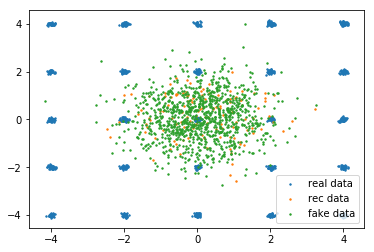

step 1000: KL: 2.630e-03, rec: 6.511e-01


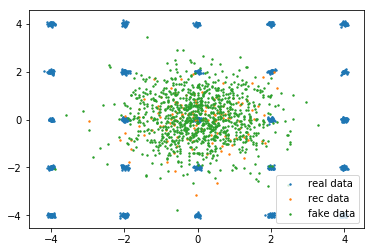

step 2000: KL: 8.858e-04, rec: 7.937e-01


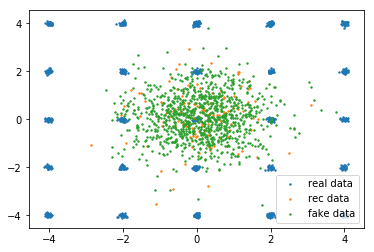

step 3000: KL: 8.112e-05, rec: 8.969e-01


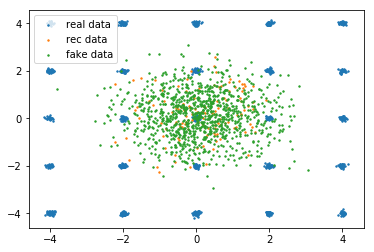

step 4000: KL: 3.028e-04, rec: 9.530e-01


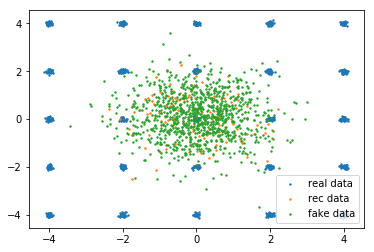

step 5000: KL: 1.335e-04, rec: 1.018e+00


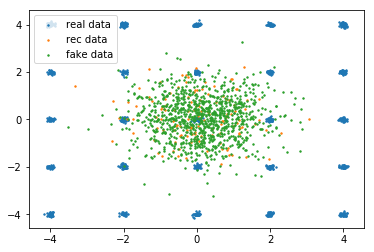

step 6000: KL: 1.280e-04, rec: 7.978e-01


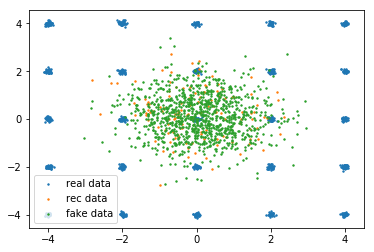

step 7000: KL: 2.294e-04, rec: 1.113e+00


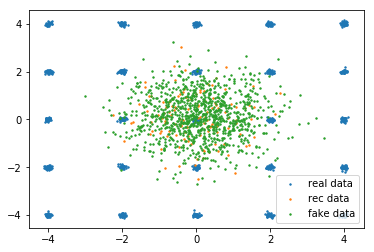

step 8000: KL: 3.091e-05, rec: 7.142e-01


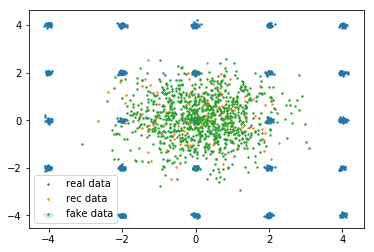

step 9000: KL: 6.917e-05, rec: 7.695e-01


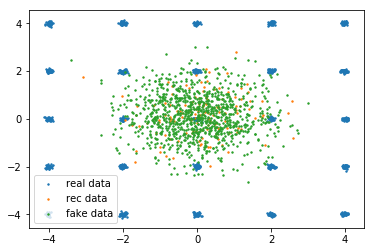

step 10000: KL: 2.882e-05, rec: 7.688e-01


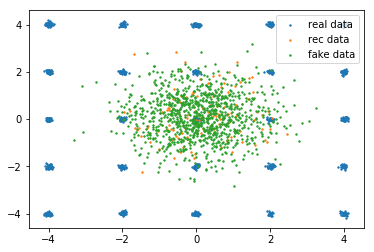

step 11000: KL: 2.709e-05, rec: 7.962e-01


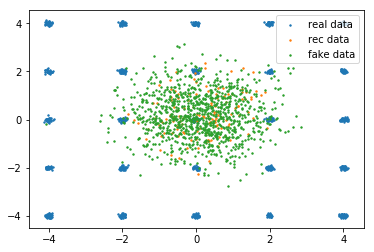

step 12000: KL: 5.740e-05, rec: 8.109e-01


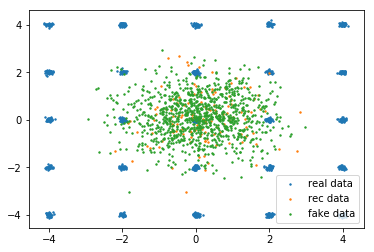

step 13000: KL: 2.310e-05, rec: 1.046e+00


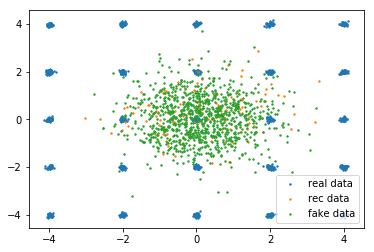

step 14000: KL: 4.259e-05, rec: 8.494e-01


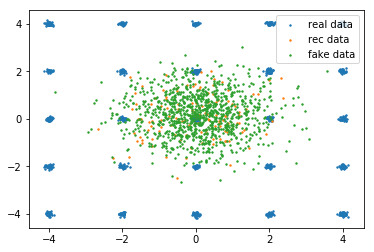

step 15000: KL: 2.491e-05, rec: 1.047e+00


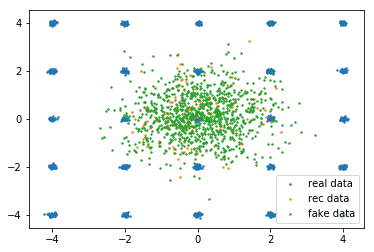

step 16000: KL: 7.591e-05, rec: 9.623e-01


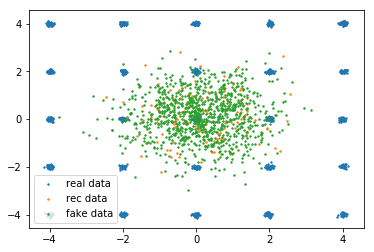

step 17000: KL: 4.816e-05, rec: 8.422e-01


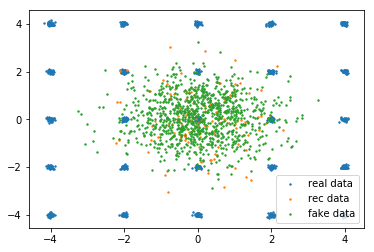

step 18000: KL: 2.083e-05, rec: 7.771e-01


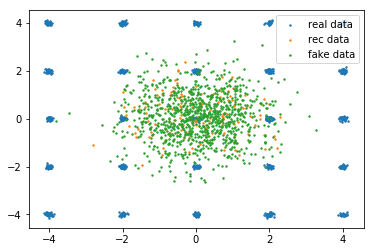

step 19000: KL: 7.153e-07, rec: 1.180e+00


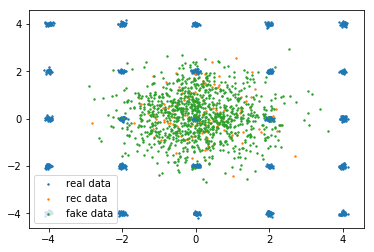

step 20000: KL: 4.509e-05, rec: 1.102e+00


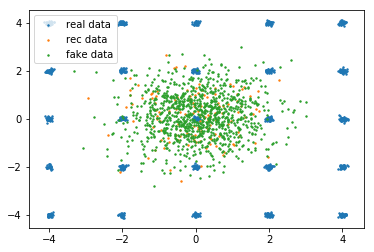

step 21000: KL: 9.641e-05, rec: 8.037e-01


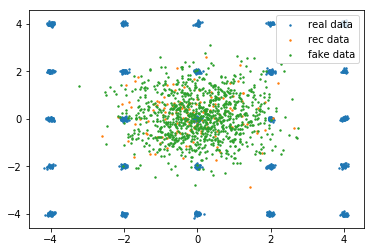

step 22000: KL: 5.722e-05, rec: 8.399e-01


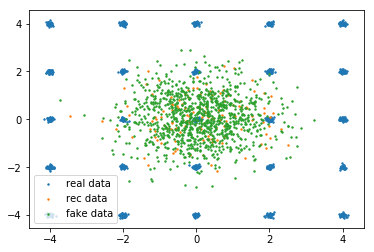

step 23000: KL: 4.196e-05, rec: 7.444e-01


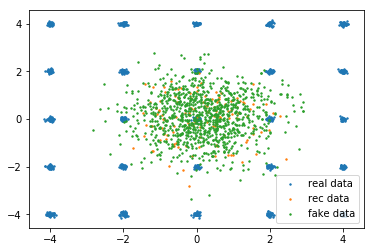

step 24000: KL: 1.411e-04, rec: 1.006e+00


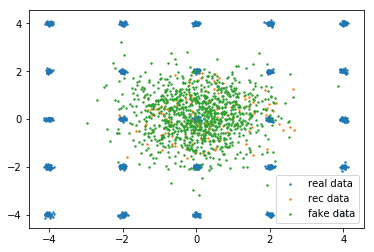

step 25000: KL: 7.629e-05, rec: 8.783e-01


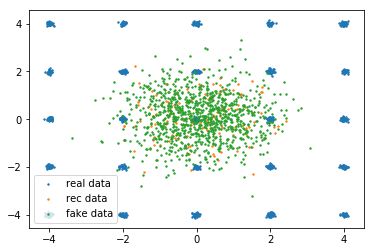

step 26000: KL: -0.000e+00, rec: 7.774e-01


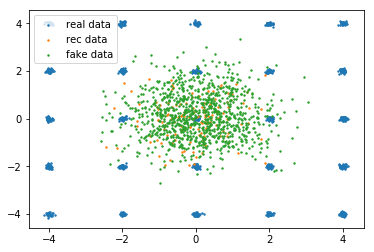

step 27000: KL: 2.670e-05, rec: 6.704e-01


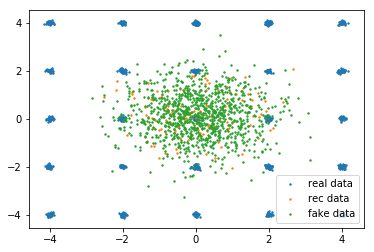

step 28000: KL: 6.866e-05, rec: 9.846e-01


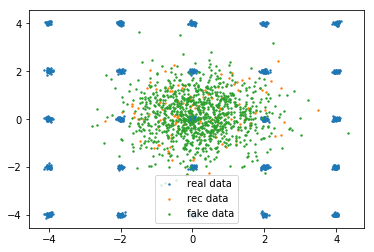

step 29000: KL: -0.000e+00, rec: 1.072e+00


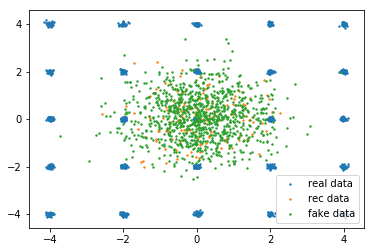

step 30000: KL: 3.433e-05, rec: 8.974e-01


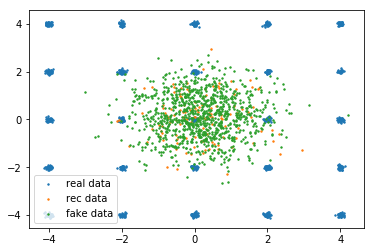

step 31000: KL: 7.629e-06, rec: 8.313e-01


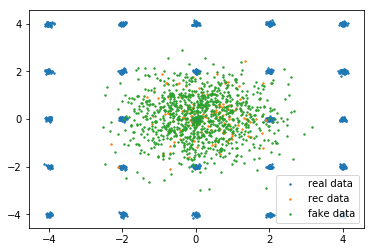

step 32000: KL: 1.183e-04, rec: 1.014e+00


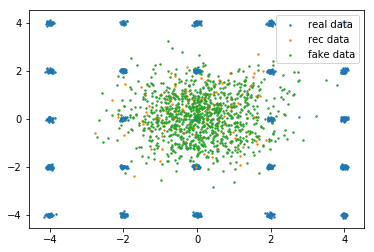

step 33000: KL: 1.144e-05, rec: 8.865e-01


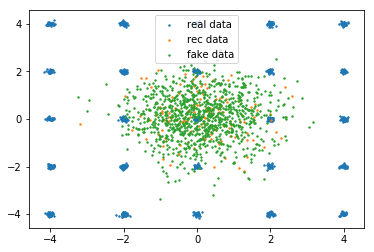

step 34000: KL: 3.433e-05, rec: 8.098e-01


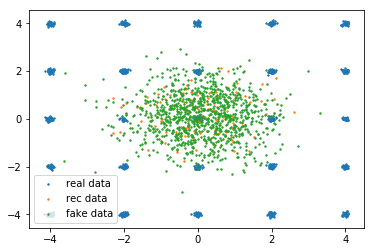

step 35000: KL: 3.815e-06, rec: 8.811e-01


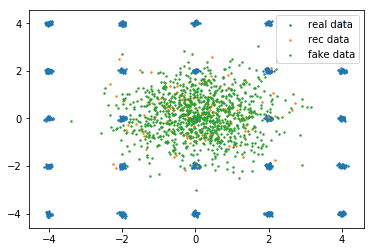

step 36000: KL: 7.629e-06, rec: 9.111e-01


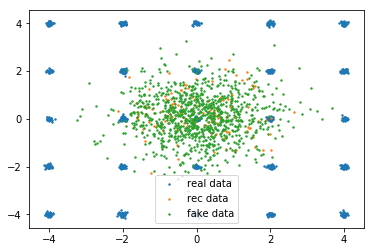

step 37000: KL: 7.629e-05, rec: 8.963e-01


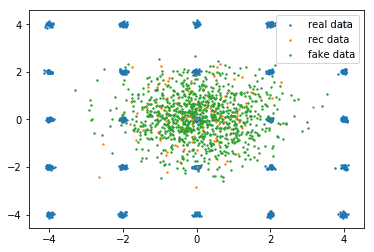

step 38000: KL: 4.196e-05, rec: 5.024e-01


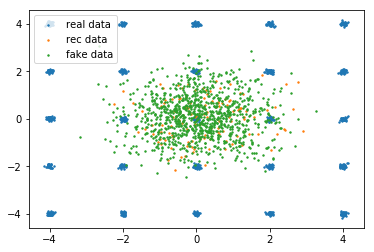

step 39000: KL: 1.907e-05, rec: 1.003e+00


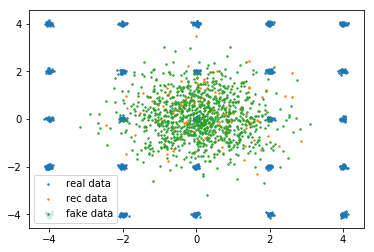

step 40000: KL: -0.000e+00, rec: 8.217e-01


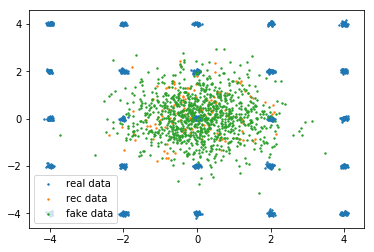

In [111]:
dtype = torch.FloatTensor

# Reparameterization Trick

def reparameterize_trick(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def compute_bce_loss(input_, target):
    """
    Computes binary cross-entropy loss function.
    """
    neg_abs = - input_.abs()
    loss = input_.clamp(min=0) - input_ * target + (1 + neg_abs.exp()).log()
    return loss.mean()

#------------------------------------------------------------------------------------------

# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    # Compute here the DKL part of the VAE loss
    
    # FILL HERE
    loss_kl = -0.5 * torch.sum(1 + enc_logvar - enc_mu.pow(2) - enc_logvar.exp())
    
    # Compute here the sample z, using Q12
    # Reparameterization Trick
    z = reparameterize_trick(enc_mu,enc_logvar)
    
    dec_mu, dec_logvar = decoder(z)
    
    # Compute here the second part of the VAE loss
    # FILL HERE 
    
    recon_x = torch.normal(dec_mu, torch.exp(0.5*dec_logvar))
    
    loss_rec = compute_bce_loss(recon_x, x)
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        fig, ax = plt.subplots()
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        ax.legend()
        plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> The main objective of the encoder network is to make approximate posterior distribution close to prior while decoder network aims at maximizing the likelihood of original input being reconstructed. Together they maximize the lower likelihood bound on the likelihood. Therefore if the $\sigma_{\theta}(z)$ is fixed and only $\mu_{\theta}(z)$ is learnt then the decoder objective to maximize the likelihood of the original input being reconstructed will be hindered. The generated samples are noisy. However the overall training of the network will be faster.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

* Impact of the Latent_N
> Different choices of dimension of the LATENT_N encodes interpretable factors of variation in the generated data. However too big or too small value of LATENT_N can cause training to diverge.

* Impact of the Width/Depth of the Encoder Network
> The main objective of the encoder network is to make approximate posterior distribution close to prior and we observe that too high or too small capacity of the encoder network will not able to achieve this objective and training will diverge.

* Impact of the Width/Depth of the Decoder Network
> The decoder network aims at maximizing the likelihood of original input being reconstructed and too high or too small capacity of the decoder network will produce extremely noisy data and the training will not converge.

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

#### Variational Autoencoders

##### Pros
* The variational autoencoder is deﬁned for arbitrary computational graphs, which makes it applicable to a wider range of probabilistic model families because there is no need to restrict the choice of models to those with tractable mean ﬁeld ﬁxed-point equations.
* One very nice property of the variational autoencoder is that simultaneously training a parametric encoder in combination with the generator network forces the model to learn a predictable coordinate system that the encoder can capture. In other words VAEs allow inference of q(z|x) which can be useful feature representation for other tasks. This makes it an excellent manifold learning algorithm.

##### Cons
* Maximizes lower bound of data likelihood but not as good as other approaches like PixelCNN and PixelRNN
* Samples blurrier and lower quality images compared to state of the art (GANs)
* One disadvantage of the variational autoencoder is that it learns an inference network for only one problem, inferring z given x.


#### Generative Adversarial Networks (GANs)

##### Pros
* State of the Art Samples are generated
* GANs do not explicitly model density function.

##### Cons
* Training the discriminator and generator together is unstable. Choice of better loss function helps to mitigate the problem.
* Can't solve inference queries such as p(x) and q(z|x)